# Simulating real-time fMRI classification

In [1]:
import nibabel as nib
import glob
import numpy as np
import os
from delphi.networks.ConvNets import BrainStateClassifier3d
from delphi.utils.plots import classification_timecourse, confusion_matrix
from delphi.utils.tools import z_transform, compute_accuracy, z_transform_volume, ToTensor
import torch
import pandas as pd
from tqdm.auto import tqdm
import pickle as pk
from delphi import mni_template

import torch
from torch.utils.data import DataLoader
from delphi.utils.datasets import NiftiDataset

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from captum.attr import GuidedBackprop
from zennit.rules import Epsilon, Gamma, Pass
from zennit.types import Convolution, Linear, Activation
from zennit.composites import LayerMapComposite
from delphi.utils.tools import save_in_mni

composite_lrp_map = [
    (Activation, Pass()),
    (Convolution, Gamma(gamma=.25)),
    (Linear, Epsilon(epsilon=0)),
]

LRP = LayerMapComposite(
    layer_map=composite_lrp_map,
)
LRP.__name__ = 'LRP'

DEVICE = torch.device("cpu")


def attribute_with_method(attributor_method, model, data, target):
    data.requires_grad = True

    attributor_name = str(attributor_method.__name__)

    if attributor_name == 'LRP':
        grad_dummy = torch.eye(model.config['n_classes'], device=torch.device("cpu"))[target]
        with attributor_method.context(model) as modified_model:
            output = modified_model(data)
            attribution, = torch.autograd.grad(output.squeeze(), data, grad_outputs=grad_dummy)

    elif attributor_name == 'GuidedBackprop':
        gbp = attributor_method(model)
        attribution = gbp.attribute(data, target)

    return attribution

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def get_real_label_vector(n_volumes, class_labels, ev_files, task_id, indices, bold_lag=5):
    real = np.ones(n_volumes)*len(class_labels)+1

    ctr = 0
    for i, ax in enumerate(class_labels):
        if "rest" in class_labels[i]:
            pass
        else:
            onset = np.ceil(pd.read_table(ev_files[ctr], header=None)/.72)
            for j, on in enumerate(onset[0].values):
                real[int(on+bold_lag):int(on+onset[1].values[0]+bold_lag)] = indices[i]+1
            ctr+=1

    rest_id = np.squeeze(np.where(np.array(f"rest_{task_id}") == np.array(class_labels)))+1
    if rest_id.size > 0:
        real[real==len(class_labels)+1] = rest_id      
    
    return (real).astype(int)-1

In [3]:
test_sub_fnames = glob.glob("../t-maps/test/body/sub*.nii.gz")
test_subs = [os.path.split(test_sub_fnames[i])[1][:9] for i in range(len(test_sub_fnames))]
print(test_subs)

['sub120515', 'sub118124', 'sub155938', 'sub103212', 'sub144933', 'sub114823', 'sub140117', 'sub131924', 'sub148032', 'sub154936', 'sub123420', 'sub138837', 'sub116726', 'sub100206', 'sub143224', 'sub157336', 'sub112516', 'sub146937', 'sub102614', 'sub137229']


## do real-time prediction with the svms

In [4]:
def z_transform_vectorized(in_vol):
    with np.errstate(invalid='ignore'):
        z = np.nan_to_num((in_vol - in_vol.mean(axis=0)) / in_vol.std(axis=0)) 
    return z

In [5]:
from nilearn.image import load_img
from nilearn.masking import apply_mask, unmask

In [6]:
svm_lbls = [["motor-w-rest", "footleft", "footright", "handleft", "handright", "tongue", "rest_MOTOR"],
                ["motor-wo-rest", "footleft", "footright", "handleft", "handright", "tongue"],
                ["wm-w-rest", "body", "face", "place", "tool","rest_WM"],
                ["wm-wo-rest", "body", "face", "place", "tool"],
                ["relation-w-rest", "match", "relation", "rest_RELATIONAL"],
                ["relation-wo-rest", "match", "relation"],
                ["social-w-rest", "mental", "rnd", "rest_SOCIAL"],
                ["social-wo-rest", "mental", "rnd"],
                ["multi-w-rest", "footleft", "footright", "handleft", "handright", "tongue", "rest_MOTOR",
                "body", "face", "place", "tool", "rest_WM",
                "match", "relation", "rest_RELATIONAL",
                "mental", "rnd", "rest_SOCIAL"],
                ["multi-wo-rest", "footleft", "footright", "handleft", "handright", "tongue",
                "body", "face", "place", "tool",
                "match", "relation",
                "mental", "rnd"]
               ]

In [51]:
# load the respective svm stuff
current_svm = svm_lbls[0]
class_labels = current_svm[1:]
with_rest = True

pca_file = f"./pca_models/{current_svm[0]}_seed2020.pkl"
with open(pca_file, 'rb') as pickle_file:
    pca = pk.load(pickle_file)

svm_file = f"./svm_models/{current_svm[0]}_ovr_seed2020.pkl"
with open(svm_file, 'rb') as pickle_file:
    svm = pk.load(pickle_file)

/home/philippseidel/anaconda3/envs/thesis-env/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator IncrementalPCA from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/philippseidel/anaconda3/envs/thesis-env/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SVC from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/philippseidel/anaconda3/envs/thesis-env/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelBinarizer from version 1.0.2 when using versi

### generate the volume wise real labels

In [52]:
TASKID = "SOCIAL"
PE = "RL" # RL

#ev_files = sorted(glob.glob(os.path.join(f"/media/philippseidel/5tb/hcp_download/{TASKID}/logs/*_{PE}.txt")))
#ev_files = sorted(glob.glob(os.path.join(f"D:/hcp_download/{TASKID}/logs/*_{PE}.txt")))
ev_files = sorted(glob.glob(os.path.join(f"/media/philippseidel/5tb/hcp_download/{TASKID}/logs/*_{PE}.txt")))
ev_files

['/media/philippseidel/5tb/hcp_download/SOCIAL/logs/mental_RL.txt',
 '/media/philippseidel/5tb/hcp_download/SOCIAL/logs/rnd_RL.txt']

In [53]:
indices = np.arange(len(class_labels))
indices

array([0, 1, 2])

In [54]:
for s, sub in tqdm(enumerate(test_subs), desc="sub"):
    path2nifti = f"/media/philippseidel/5tb/hcp_download/{TASKID}/{sub}_{PE}.nii.gz"
    
    # load data of a subject
    try:
        data = apply_mask(load_img(path2nifti), mni_template)
    except:
        print(path2nifti + "not found. Continuing")
    # z_transform the data
    data_z = z_transform_vectorized(data)
    if s==0:
        y_score = np.zeros((data_z.shape[0], len(class_labels), len(test_subs)))
        real = get_real_label_vector(data_z.shape[0], class_labels, ev_files, TASKID, indices, bold_lag=5)
    # pca transform
    test_transformed = pca.transform(data_z)
    # get prediction probas
    y_score[:,:,s] = svm.predict_proba(test_transformed)

sub: 0it [00:00, ?it/s]

# Compute prediction probabilities for the CNN

In [55]:
#load a CNN
volume_model = BrainStateClassifier3d(f"../05_volumetric_approach/models/{TASKID.lower()}-w-rest-real/seed-2020_fold-00")

if TASKID == "WM":
    t_model = BrainStateClassifier3d(f"../04_transfer_learning/models/from-scratch/WM_samplesize-120_seed-2020_fold-01")
if TASKID == "SOCIAL":
    t_model = BrainStateClassifier3d(f"../04_transfer_learning/models/from-scratch/social_samplesize-120_seed-2020_fold-09")
if TASKID == "RELATIONAL":
    t_model = BrainStateClassifier3d(f"../04_transfer_learning/models/from-scratch/relational_samplesize-120_seed-2020_fold-07")
if TASKID == "MOTOR":
    t_model = BrainStateClassifier3d(f"../04_transfer_learning/models/from-scratch/motor_samplesize-120_seed-1224_fold-05")

Loading from config file ../05_volumetric_approach/models/social-w-rest-real/seed-2020_fold-00/config.yaml
Loading from config file ../04_transfer_learning/models/from-scratch/social_samplesize-120_seed-2020_fold-09/config.yaml


In [56]:
for s, sub in tqdm(enumerate(test_subs), desc="testsubs"):
    path2nifti = f"/media/philippseidel/5tb/hcp_download/{TASKID}/{sub}_{PE}.nii.gz"
    #path2nifti = f"D:/hcp_download/{TASKID}/{sub}_{PE}.nii.gz"
    # load the data
    try:
        data = nib.load(path2nifti).get_fdata()
    except:
        print(path2nifti + "not found. Continuing")
    data = np.nan_to_num(z_transform(data))
    
    data = torch.tensor(data)
    
    if s == 0:
        predicted_volume = np.zeros((data.size()[-1], len(test_subs)))
        probs_volume = np.zeros((data.size()[-1], volume_model.config["n_classes"], len(test_subs)))
        
        predicted_t = np.zeros((data.size()[-1], len(test_subs)))
        probs_t = np.zeros((data.size()[-1], t_model.config["n_classes"], len(test_subs)))
        mu_attr_vol = np.zeros_like(data)
        
    for i in tqdm(range(data.size()[-1]), desc="volumes"):
        in_vol = data[:,:,:,i].unsqueeze(0).unsqueeze(0).float()

        # get the predictions for the model trained on volumes
        out = volume_model.SM(volume_model(in_vol.float()))
        probs_volume[i,:,s] = out.detach().cpu().numpy()
        predicted_volume[i,s] = np.argmax(probs_volume[i,:, s])
        
        # get the predictions for the model trained on t-maps
        out = t_model.SM(t_model(in_vol.float()))
        probs_t[i,:,s] = out.detach().cpu().numpy()
        predicted_t[i,s] = np.argmax(probs_t[i,:, s])        
        
        # compute the attributions for each volume
        #attribution = attribute_with_method(LRP, volume_model, in_vol, real[i])
        #mu_attr_vol[:,:,:,i] += attribution.squeeze().squeeze().detach().numpy()/len(test_subs)

#save_in_mni(mu_attr_vol, f"lrp/avg_{TASKID}_{PE}_w-rest.nii.gz" if with_rest else f"lrp/avg_{TASKID}_{PE}_wo-rest.nii.gz")

testsubs: 0it [00:00, ?it/s]

volumes:   0%|          | 0/274 [00:00<?, ?it/s]

volumes:   0%|          | 0/274 [00:00<?, ?it/s]

volumes:   0%|          | 0/274 [00:00<?, ?it/s]

volumes:   0%|          | 0/274 [00:00<?, ?it/s]

volumes:   0%|          | 0/274 [00:00<?, ?it/s]

volumes:   0%|          | 0/274 [00:00<?, ?it/s]

volumes:   0%|          | 0/274 [00:00<?, ?it/s]

volumes:   0%|          | 0/274 [00:00<?, ?it/s]

volumes:   0%|          | 0/274 [00:00<?, ?it/s]

volumes:   0%|          | 0/274 [00:00<?, ?it/s]

volumes:   0%|          | 0/274 [00:00<?, ?it/s]

volumes:   0%|          | 0/274 [00:00<?, ?it/s]

volumes:   0%|          | 0/274 [00:00<?, ?it/s]

volumes:   0%|          | 0/274 [00:00<?, ?it/s]

volumes:   0%|          | 0/274 [00:00<?, ?it/s]

volumes:   0%|          | 0/274 [00:00<?, ?it/s]

volumes:   0%|          | 0/274 [00:00<?, ?it/s]

volumes:   0%|          | 0/274 [00:00<?, ?it/s]

volumes:   0%|          | 0/274 [00:00<?, ?it/s]

volumes:   0%|          | 0/274 [00:00<?, ?it/s]

In [57]:
for i in range(20):
    if i == 0:
        svm_preds = np.argmax(y_score[:, :, i], axis=1)
        cnn_preds = np.argmax(probs_volume[:, :, i], axis=1)
        t_preds = np.argmax(probs_t[:, :, i], axis=1)
        
    else:
        svm_preds = np.hstack((svm_preds, np.argmax(y_score[:, :, i], axis=1)))
        cnn_preds = np.hstack((cnn_preds, np.argmax(probs_volume[:, :, i], axis=1)))
        t_preds = np.hstack((t_preds, np.argmax(probs_t[:, :, i], axis=1)))


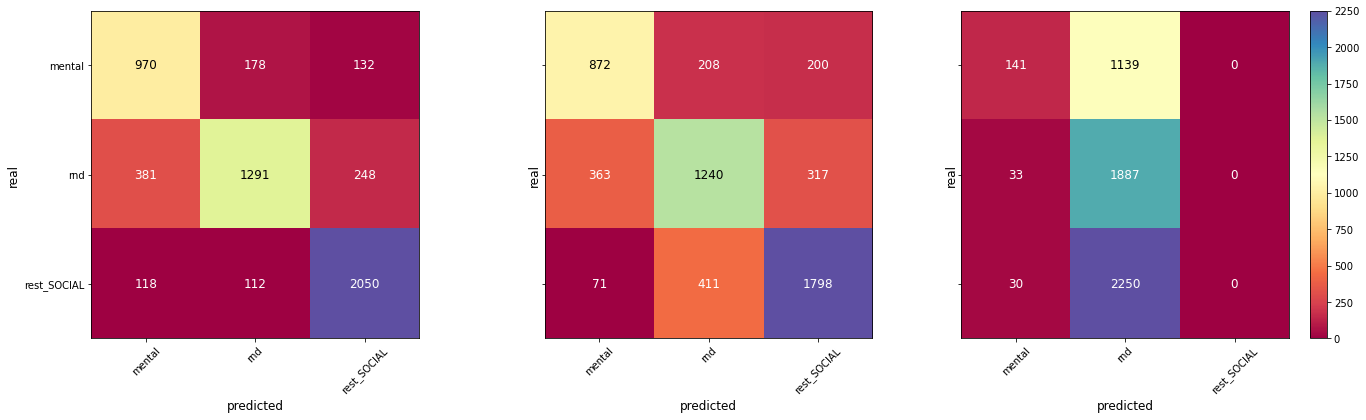

In [58]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=True, gridspec_kw={'width_ratios': [1, 1, 1]})
_ = confusion_matrix(np.tile(real, len(test_subs)), svm_preds, class_labels, ax=axes[0]);
#axes[0].set_title("summed confmat: svm")
_ = confusion_matrix(np.tile(real, len(test_subs)), cnn_preds, class_labels, ax=axes[1])
#axes[1].set_title("summed confmat: CNN")
_, conf_ax = confusion_matrix(np.tile(real, len(test_subs)), t_preds, class_labels, ax=axes[2])
#axes[1].set_title("summed confmat: CNN")
fig.colorbar(conf_ax, ax=axes[2])

fig.tight_layout()
plt.savefig(f'figures/summed_confmat_{TASKID}_{PE}_w-rest.pdf' if with_rest else f'figures/summed_confmat_{TASKID}_{PE}_wo-rest.pdf', facecolor=fig.get_facecolor(), transparent=True)

In [59]:
from scipy.stats import ttest_1samp
accs = np.zeros((len(test_subs),3))

for i in range(len(test_subs)):
    accs[i, 0] = compute_accuracy(real, np.argmax(y_score[:, :, i], axis=1)) # SVM volumes
    accs[i, 1] = compute_accuracy(real, predicted_volume[:, i]) # CNN volumes
    accs[i, 2] = compute_accuracy(real, predicted_t[:, i]) # CNN t

print(ttest_1samp(accs[:, 0]-accs[:, 1], 0))
print(ttest_1samp(accs[:, 1]-accs[:, 2], 0))

df = pd.DataFrame(accs.tolist(), columns=["svm", "cnn_vol", "cnn_t"])
df.to_csv(f"stats/accs_{TASKID}_{PE}_w-rest.csv" if with_rest else f"stats/accs_{TASKID}_{PE}_wo-rest.csv", index=False)

Ttest_1sampResult(statistic=4.818677734829125, pvalue=0.00011934682026233754)
Ttest_1sampResult(statistic=19.054304234248843, pvalue=7.668149643730534e-14)


In [60]:
print(f"Across subjects average classification accuracy over whole time course for {TASKID} task (SVM):", accs[:,0].mean(), "+/-", accs[:,0].std()/np.sqrt(len(test_subs)), "(s.e.m)")
print(f"Across subjects average classification accuracy over whole time course for {TASKID} task trained on volumes:", accs[:,1].mean(), "+/-", accs[:,1].std()/np.sqrt(len(test_subs)), "(s.e.m)")
print(f"Across subjects average classification accuracy over whole time course for {TASKID} task trained on tmaps:", accs[:,2].mean(), "+/-", accs[:,2].std()/np.sqrt(len(test_subs)), "(s.e.m)")

Across subjects average classification accuracy over whole time course for SOCIAL task (SVM): 0.7866788321167884 +/- 0.01405814355386762 (s.e.m)
Across subjects average classification accuracy over whole time course for SOCIAL task trained on volumes: 0.7135036496350365 +/- 0.017770200043620267 (s.e.m)
Across subjects average classification accuracy over whole time course for SOCIAL task trained on tmaps: 0.37007299270072996 +/- 0.0026114662510946444 (s.e.m)


In [61]:
# let's be more fair for the t-map trained NN and remove the rest parts
accs2 = np.zeros_like(accs)

real_cropped = real
real_cropped = np.delete(real_cropped, np.where(real==indices[-1]))

for i in range(len(test_subs)):
    predicted_svm_cropped = np.argmax(y_score[:,:-1,i], axis=1)
    predicted_svm_cropped = np.delete(predicted_svm_cropped, np.where(real==indices[-1]))

    predicted_volume_cropped = np.argmax(probs_volume[:,:-1,i], axis=1)
    predicted_volume_cropped = np.delete(predicted_volume_cropped, np.where(real==indices[-1]))

    predicted_t_cropped = np.argmax(probs_t[:,:,i], axis=1)    
    predicted_t_cropped = np.delete(predicted_t_cropped, np.where(real==indices[-1]))
    
    if i == 0:
        svm_cropped = predicted_svm_cropped
        cnn_cropped = predicted_volume_cropped
        t_cropped = predicted_t_cropped
        
    else:
        svm_cropped = np.hstack((svm_cropped, predicted_svm_cropped))
        cnn_cropped = np.hstack((cnn_cropped, predicted_volume_cropped))
        t_cropped = np.hstack((t_cropped, predicted_t_cropped))
    
    accs2[i, 0] = compute_accuracy(real_cropped, predicted_svm_cropped)
    accs2[i, 1] = compute_accuracy(real_cropped, predicted_volume_cropped)
    accs2[i, 2] = compute_accuracy(real_cropped, predicted_t_cropped)

print(ttest_1samp(accs2[:,0]-accs2[:,1], 0))
print(ttest_1samp(accs2[:,0]-accs2[:,2], 0))
print(ttest_1samp(accs2[:,1]-accs2[:,2], 0))

df = pd.DataFrame(accs2.tolist(), columns=["svm", "cnn_vol", "cnn_t"])
df.to_csv(f"stats/accs_cropped_{TASKID}_{PE}_w-rest.csv" if with_rest else f"stats/accs_cropped_{TASKID}_{PE}_wo-rest.csv", index=False)

Ttest_1sampResult(statistic=0.641884945765803, pvalue=0.528616832087019)
Ttest_1sampResult(statistic=7.739619870393577, pvalue=2.7300001452723594e-07)
Ttest_1sampResult(statistic=10.404598282721052, pvalue=2.767752724756667e-09)


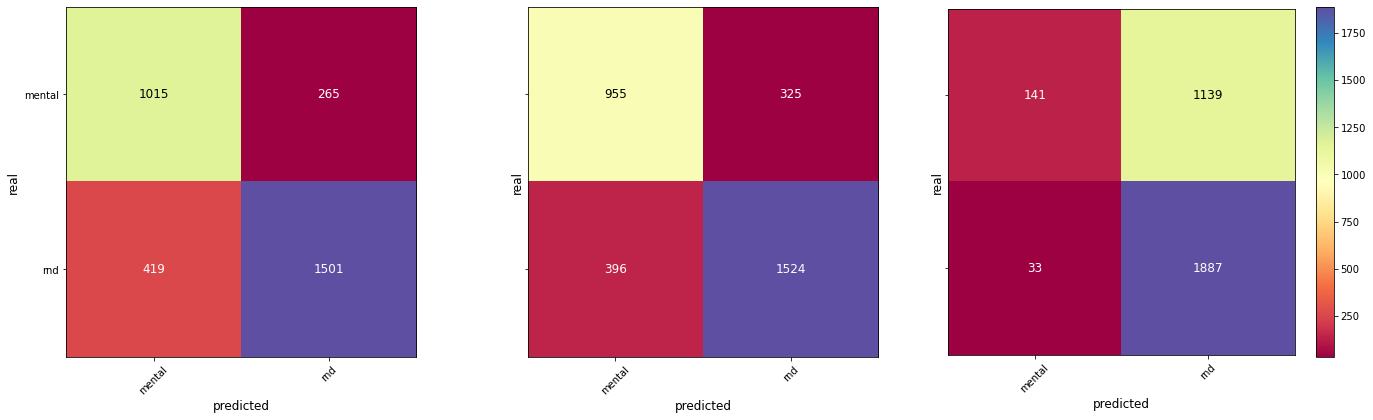

In [62]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=True, gridspec_kw={'width_ratios': [1, 1, 1]})
_ = confusion_matrix(np.tile(real_cropped, len(test_subs)), svm_cropped, class_labels[:-1], ax=axes[0]);
#axes[0].set_title("summed confmat: svm")
_ = confusion_matrix(np.tile(real_cropped, len(test_subs)), cnn_cropped, class_labels[:-1], ax=axes[1])
#axes[1].set_title("summed confmat: CNN")
_, conf_ax = confusion_matrix(np.tile(real_cropped, len(test_subs)), t_cropped, class_labels[:-1], ax=axes[2])
#axes[1].set_title("summed confmat: CNN")
fig.colorbar(conf_ax, ax=axes[2])

fig.tight_layout()
plt.savefig(f'figures/summed_confmat_{TASKID}_{PE}_w-rest_cropped.pdf' if with_rest else f'figures/summed_confmat_{TASKID}_{PE}_wo-rest_cropped.pdf', facecolor=fig.get_facecolor(), transparent=True)

In [63]:
print(f"Across subjects average classification accuracy over cropped time course for {TASKID} task (SVM):", accs2[:,0].mean(), "+/-", accs2[:,0].std()/np.sqrt(len(test_subs)), "(s.e.m)")
print(f"Across subjects average classification accuracy over cropped time course for {TASKID} task trained on volumes:", accs2[:,1].mean(), "+/-", accs2[:,1].std()/np.sqrt(len(test_subs)), "(s.e.m)")
print(f"Across subjects average classification accuracy over cropped time course for {TASKID} task trained on tmaps:", accs2[:,2].mean(), "+/-", accs2[:,2].std()/np.sqrt(len(test_subs)), "(s.e.m)")

Across subjects average classification accuracy over cropped time course for SOCIAL task (SVM): 0.78625 +/- 0.017818529681205456 (s.e.m)
Across subjects average classification accuracy over cropped time course for SOCIAL task trained on volumes: 0.7746875 +/- 0.013437318312725198 (s.e.m)
Across subjects average classification accuracy over cropped time course for SOCIAL task trained on tmaps: 0.6337499999999999 +/- 0.004472135954999577 (s.e.m)


### show some classification time-course (average across all test-subjects)

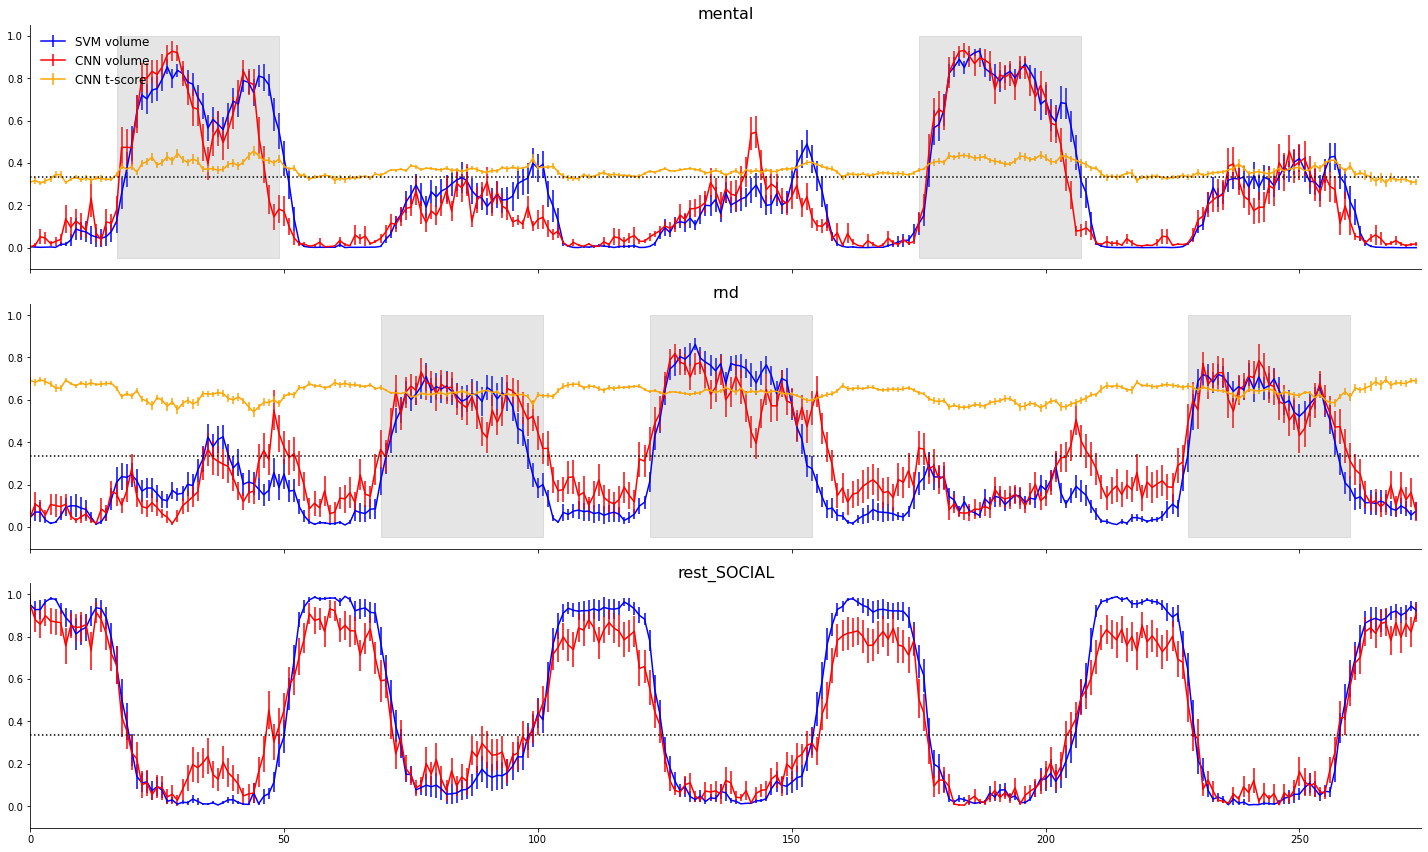

In [64]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(class_labels),1, figsize=(20,12), sharex=True, sharey=True)

x = np.arange(len(y_score))*.72

# the HRF peaks at about 4-6 seconds after the stimulus onset.
bold_lag = 5

mu_svm = y_score.mean(axis=2)
sem_svm = y_score.std(axis=2)/(np.sqrt(len(test_subs)))

mu_vol = probs_volume.mean(axis=2)
sem_vol = probs_volume.std(axis=2)/np.sqrt(len(test_subs))

mu_t = probs_t.mean(axis=2)
sem_t = probs_t.std(axis=2)/np.sqrt(len(test_subs))

ctr = 0
for i, ax in enumerate(axes):
    ax.errorbar(np.arange(len(mu_svm)), mu_svm[:, i], sem_svm[:,i], color='blue', zorder=1, label="SVM volume")
    ax.errorbar(np.arange(len(mu_vol)), mu_vol[:, i], sem_vol[:,i], color='red', zorder=1, label="CNN volume")
    if i < len(class_labels)-1:
            ax.errorbar(np.arange(len(mu_t)), mu_t[:, i], sem_t[:,i], color='orange', zorder=1, label="CNN t-score")
    ax.axhline(1/len(class_labels), color="black", linestyle=":")
    ax.set_title(class_labels[i])
    if "rest" in class_labels[i]:
        pass
    else:
        onset = np.ceil(pd.read_table(ev_files[ctr], header=None)/.72)
        for j, on in enumerate(onset[0].values):
            rect=mpatches.Rectangle((on+bold_lag, -.05),onset[1].values[0], 1.05, 
                        fill = True, alpha=.2,
                        color = "gray",
                        linewidth = 1)
            ax.add_patch(rect)
        ctr+=1
    ax.spines[["right", "top"]].set_visible(False)
    ax.set_xlim([0, len(x)])
    if i == 0:
        ax.legend(loc="upper left", frameon=False)
fig.tight_layout()

plt.savefig(f'figures/tc_{TASKID}_{PE}_w-rest.pdf' if with_rest else f'figures/tc_{TASKID}_{PE}_wo-rest.pdf', facecolor=fig.get_facecolor(), transparent=True)

# Stats

In [65]:
import seaborn as sns

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## ACCS AND CONF MATS FOR THE TEST DATA OF THE SVMS AND DNNs

In [7]:
# svm accs
df_svm = pd.read_csv("stats/svm_test_acc.csv")
df_svm = df_svm[df_svm['condition'].str.contains("-w-", case=False)]
df_svm = df_svm.drop(columns="n_samples")
df_svm = df_svm.drop(df_svm[df_svm["condition"] == "multi-w-rest"].index)
df_svm["model"] = "svm"
df_svm

,acc,condition,model
0,0.779167,motor-w-rest,svm
2,0.705000,wm-w-rest,svm
4,0.850000,relation-w-rest,svm
6,0.816667,social-w-rest,svm


In [8]:
# cnn_vol accs
tasks = ["motor", "wm", "relation", "social"]

df_cnn_vol = pd.DataFrame(columns=["acc", "condition", "model"])
for i, task in enumerate(tasks):
    if task == "relation":
        df = pd.read_csv(f"../05_volumetric_approach/models/{task}al-w-rest-real/seed-2020_fold-00/test_stats.csv")
    else:
        df = pd.read_csv(f"../05_volumetric_approach/models/{task}-w-rest-real/seed-2020_fold-00/test_stats.csv")
    acc = compute_accuracy(df["real"], df["predicted"])
    df_cnn_vol = pd.concat([df_cnn_vol, pd.DataFrame({"acc": acc, "condition": f"{task}-w-rest", "model": "cnn_vol"}, index=[i])])
    
df_cnn_vol

,acc,condition,model
0,0.770833,motor-w-rest,cnn_vol
1,0.755000,wm-w-rest,cnn_vol
2,0.783333,relation-w-rest,cnn_vol
3,0.833333,social-w-rest,cnn_vol


In [ ]:
# cnn_t accs
tasks = ["motor", "wm", "relation", "social"]

df_cnn_t = pd.DataFrame(columns=["acc", "condition", "model"])
for i, task in enumerate(tasks):
    if task == "wm":
        t_model = BrainStateClassifier3d(f"../04_transfer_learning/models/from-scratch/WM_samplesize-120_seed-2020_fold-01")
    if task == "social":
        t_model = BrainStateClassifier3d(f"../04_transfer_learning/models/from-scratch/social_samplesize-120_seed-2020_fold-09")
        t_model.config["class_labels"][-1] = "rnd"
    if task == "relation":
        t_model = BrainStateClassifier3d(f"../04_transfer_learning/models/from-scratch/relational_samplesize-120_seed-2020_fold-07")
    if task == "motor":
        t_model = BrainStateClassifier3d(f"../04_transfer_learning/models/from-scratch/motor_samplesize-120_seed-1224_fold-05")
    
    # setup the dataset
    test_data = DataLoader(NiftiDataset("../v-maps/test", t_model.config["class_labels"], 0, DEVICE, transform=ToTensor()), batch_size=5, shuffle=False)
    _, tstats = t_model.fit(test_data, device=DEVICE, train=False)
    df_test = pd.DataFrame(tstats.tolist(), columns=[*t_model.config["class_labels"], *["real", "predicted"]])
    df_test.to_csv(f"stats/cnn_t_{task}_test_stats.csv", index=False)    
    acc = compute_accuracy(tstats[:, -2], tstats[:, -1])
    df_cnn_t = pd.concat([df_cnn_t, pd.DataFrame({"acc": acc, "condition": f"{task}-w-rest", "model": "cnn_t"}, index=[i])])

Loading from config file ../04_transfer_learning/models/from-scratch/motor_samplesize-120_seed-1224_fold-05/config.yaml


0it [00:00, ?it/s]

Loading from config file ../04_transfer_learning/models/from-scratch/WM_samplesize-120_seed-2020_fold-01/config.yaml


0it [00:00, ?it/s]

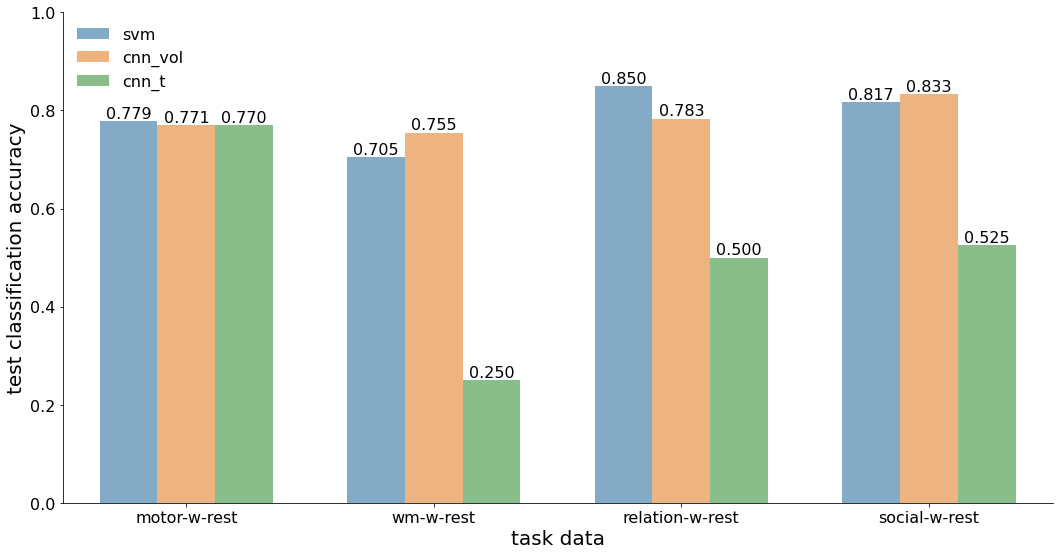

In [69]:
df_accs = pd.concat([df_svm, df_cnn_vol, df_cnn_t])
fig, ax = plt.subplots(figsize=(15, 8))
test = sns.barplot(ax=ax, data=df_accs, x="condition", y="acc", hue="model", alpha=.6, width=.7)
ax.set_ylim([0, 1])
ax.spines[["top", "right"]].set_visible(False)
ax.legend(frameon=False)
ax.set_ylabel("test classification accuracy")
ax.set_xlabel("task data")
for i in ax.containers:
    ax.bar_label(i,fmt="%1.3f")
    
fig.tight_layout()
plt.savefig(f'figures/testset_accs.pdf', facecolor=fig.get_facecolor(), transparent=True)

In [ ]:
from nilearn.image import load_img
from nilearn.masking import apply_mask, unmask
from delphi import mni_template
def load_data(n, data_dir, classes, split, brain_mask=None):
    
    for i, label in tqdm(enumerate(classes), desc="class"):
        file_list = glob.glob(os.path.join(data_dir, split, label, 'sub*.nii.gz'))
        file_list = file_list[:n]
        if i == 0:
            data = apply_mask(load_img(file_list), brain_mask)
        else:
            data = np.vstack((data, apply_mask(load_img(file_list), brain_mask)))
    
    return data

In [ ]:
# plot the confusion matrices
svm_idx = [0, 2, 4, 6]


for i, idx in enumerate(svm_idx):
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    task = tasks[i]
    current_svm = svm_lbls[idx]
    class_labels = current_svm[1:]

    pca_file = f"./pca_models/{current_svm[0]}_seed2020.pkl"
    with open(pca_file, 'rb') as pickle_file:
        pca = pk.load(pickle_file)

    svm_file = f"./svm_models/{current_svm[0]}_ovr_seed2020.pkl"
    with open(svm_file, 'rb') as pickle_file:
        svm = pk.load(pickle_file)
        
    test_data = load_data(40, "../v-maps/", class_labels, "test", brain_mask=mni_template)
    test_lbls = np.repeat(np.arange(len(class_labels)), 40)
    
    # pca transform
    test_transformed = pca.transform(test_data)
    
    # get prediction probas
    y_score = svm.predict_proba(test_transformed)
    pred = np.argmax(y_score, axis=1)
    
    _ = confusion_matrix(test_lbls, pred, class_labels, ax=axes[0],  **{"vmax": 40})
    
    if task == "relation":
        df = pd.read_csv(f"../05_volumetric_approach/models/{task}al-w-rest-real/seed-2020_fold-00/test_stats.csv")
    else:
        df = pd.read_csv(f"../05_volumetric_approach/models/{task}-w-rest-real/seed-2020_fold-00/test_stats.csv")
    _ = confusion_matrix(df["real"], df["predicted"], class_labels, ax=axes[1],  **{"vmax": 40})
    
    df = pd.read_csv(f"stats/cnn_t_{task}_test_stats.csv")
    _, conf_ax = confusion_matrix(df["real"], df["predicted"], class_labels[:-1], ax=axes[2], **{"vmax": 40})
    fig.colorbar(conf_ax, ax=axes[2])
    
    fig.tight_layout()
    
    plt.savefig(f'figures/testset_{task}_confmat.pdf', facecolor=fig.get_facecolor(), transparent=True)

## ACCS FOR THE TIME COURSES

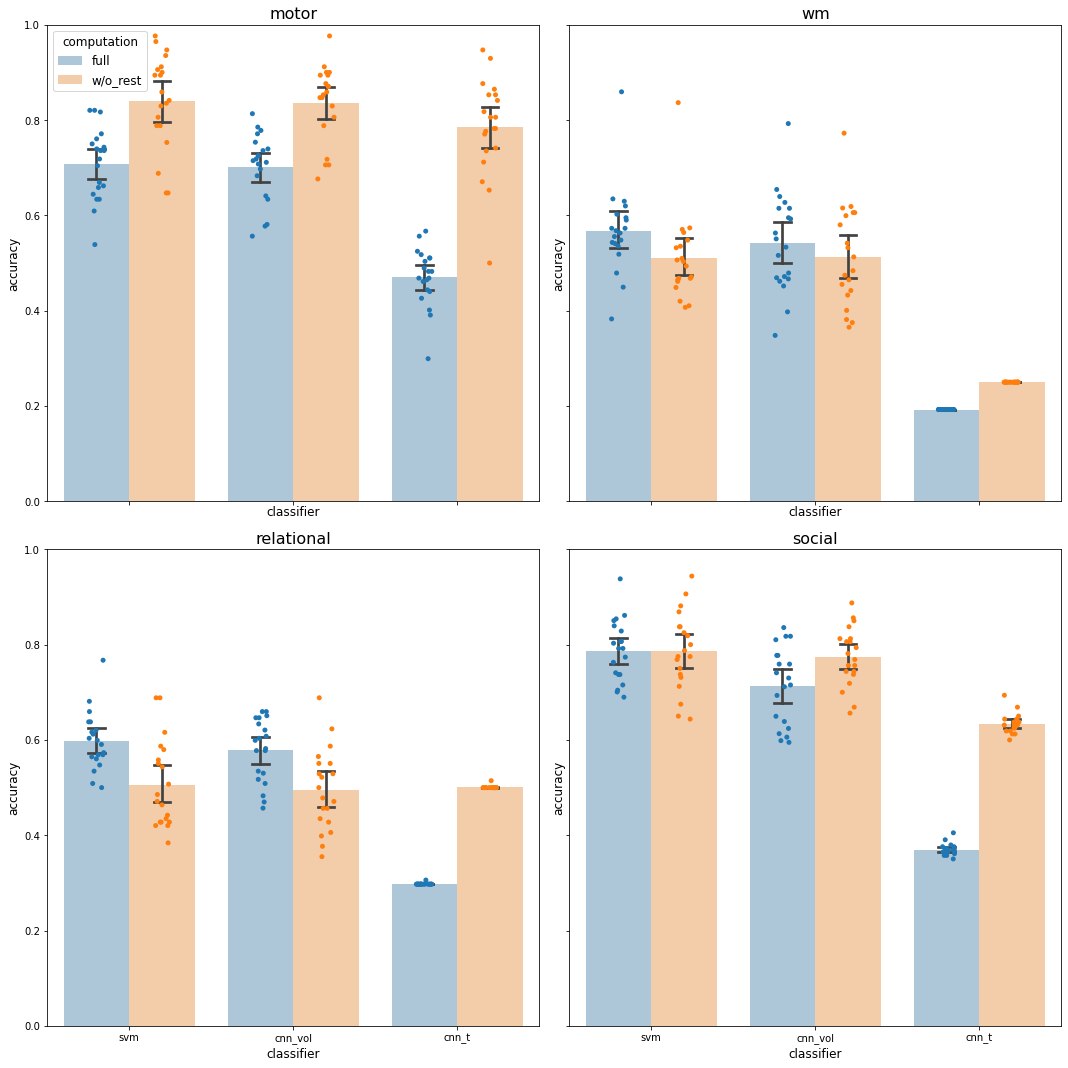

In [73]:
tasks = ["MOTOR", "WM", "RELATIONAL", "SOCIAL"]

fig, axes = plt.subplots(2,2,figsize=(15, 15), sharex=True, sharey=True)
ax = axes.flatten()
for i, task in enumerate(tasks):
    df = pd.read_csv(f"stats/accs_{task}_RL_w-rest.csv")
    df = df.melt(value_name="accuracy", var_name="classifier");
    df["computation"] = "full"

    df2 = pd.read_csv(f"stats/accs_cropped_{task}_RL_w-rest.csv")
    df2 = df2.melt(value_name="accuracy", var_name="classifier");
    df2["computation"] = "w/o_rest"

    df_cat = pd.concat([df, df2])

    sns.barplot(ax=ax[i], data=df_cat, x="classifier", y="accuracy", hue="computation", 
                errorbar=("ci", 95), n_boot=5000, capsize=.1, alpha=.4)
    sns.stripplot(ax=ax[i], data=df_cat, x="classifier", y="accuracy", hue="computation", dodge=True, legend=False)
    
    ax[i].set_title(task.lower())
    ax[i].set_ylim([0, 1])
    
    if i > 0:
        ax[i].legend([], frameon=False)
        
fig.tight_layout()
plt.savefig(f'figures/real_time_clstats.pdf', facecolor=fig.get_facecolor(), transparent=True)

In [ ]:
x = np.linspace(-10, 10, 100)
amp = [0.2, 0.3, 0.5, 0.75, 1]
z = 1/(1 + np.exp(-x)) + np.random.rand(len(x))/5
  
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(x, z, linewidth=2)
ax.set_xlabel("time")
ax.set_ylabel("brain state")
ax.set_yticks([.1, 1.2], ["sad", "happy"])
ax.axes.get_xaxis().set_ticks([])
ax.set_title("operant conditioning")
ax.spines[["top", "right"]].set_visible(False)
plt.savefig(f'figures/fmri_nf_sim.pdf', facecolor=fig.get_facecolor(), transparent=True)